In [68]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN

from geopy.distance import great_circle
from shapely.geometry import MultiPoint


from shapely.geometry import Point
import pyproj
geod = pyproj.Geod(ellps='WGS84')

from scipy import stats

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")

    
import os
import glob
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Cell Data Comparison to Census
This data is intended to compare the difference between the Cell Data and cenus Tract and Block Group data. 

Census data investigated here: 
- 2014 - 2018 5YR ACS Tracts
- 2014 - 2018 5YR ACS Block groups
- 2018 1YR ACS Tracts

## 0.Get Data

### 0.1 Read all home locations for each day

Testing this on Jul1 for now

In [2]:
li = []
for each in glob.glob('/Volumes/Elements/Cuebiq/01_Analysis/Results_150m_10m_ALL/home_locs*.csv'):
    df = pd.read_csv(each, index_col=None, header=0)
    li.append(df)
    date = each.split('/')[-1].split("_")[-1].split('.')[0]
    df['date'] = date
home = pd.concat(li, axis=0, ignore_index=True)


In [617]:
home.shape

(736968, 6)

#### 0.1.1 Find the average lat/lng of all the user points and say this is home.

Going to use DBSCAN for thsi to get more accurate home locations

In [ ]:
# home_dask = dd.from_pandas(home, npartitions=4)


In [ ]:
# def cluster_homelocs(df):
#     kms_per_radian = 6371.0088
#     epsilon = .15 / kms_per_radian
#     est = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine')
#     pred = est.fit_predict(np.radians(df[['home_lng','home_lat']]))
#     df['labels']= pred

#     num_home_locs = len(df['labels'].unique())
#     std_dev_home_locs = df.groupby('labels')[['home_lng','home_lat']].std().values[0]
#     best_guess_label = stats.mode(pred,axis=None).mode[0]
#     avg = df[df.labels==best_guess_label].mean()
    
#     return avg['home_lng'],avg['home_lat'],num_home_locs,std_dev_home_locs

# # test = home.head(100).groupby('uid').apply(cluster_homelocs)

# home_locs_stats = home_dask.groupby('uid').apply(cluster_homelocs).compute()

In [ ]:
# home1 = pd.merge(home,pd.DataFrame(home_locs_stats.reset_index()), on='uid')[['uid',0]]

# home1['home_lng'] = home1.apply(lambda x: x[0][0],axis=1)
# home1['home_lat'] = home1.apply(lambda x: x[0][1],axis=1)
# home1['num_home_locs'] = home1.apply(lambda x: x[0][2],axis=1)
# home1['std_lng'] = home1.apply(lambda x: x[0][3][0],axis=1)
# home1['std_lat'] = home1.apply(lambda x: x[0][3][1],axis=1)
# home1= home1.groupby('uid').first().reset_index()

In [69]:
# home1.to_pickle('home_loc_MOREINFO.pickle')
home1 = pd.read_pickle('home_loc_MOREINFO.pickle')

In [70]:
home1.shape

(129997, 7)

Make a geopandas dataframe 

In [71]:
geometry = [Point(xy) for xy in zip(home1.home_lng, home1.home_lat)]
crs = {'init': 'epsg:4326'} 
home2 = gpd.GeoDataFrame(home1, crs=crs, geometry=geometry)

### 0.2 Read all stay locations for each day

#### 0.2.1 Stays only for residents
Only use the stays where have the home address

In [72]:
# li = []
# for each in glob.glob('/Volumes/Elements/Cuebiq/01_Analysis/Results_150m_10m_ALL/stay*.csv'):
#     df = pd.read_csv(each, index_col=None, header=0)
#     li.append(df)
#     date = each.split('/')[-1].split("_")[-1].split('.')[0]
#     df['date'] = date
# stays = pd.concat(li, axis=0, ignore_index=True)

# stays = pd.concat(li, axis=0, ignore_index=True)
# stays = stays.sort_values(['uid','trip_label','datetime'])
# stays.reset_index(drop=True,inplace=True)


# stays1 = stays[stays.uid.isin(home2.uid)]
# stays1['datetime']=pd.to_datetime(stays1['datetime'])
# stays1['day']=pd.to_datetime(stays1['datetime']).dt.day

#### 0.2.2 Get stay start/end
Get the stay **centroids** and find the start/end of the stay

**QUESTION: Aren't these locations already centroids??**

**ANSWER: No**

In [73]:
# stay_loc = stays1.groupby(['uid','date','trip_label','stay_label'])\
#                 .mean()\
#                 .reset_index()[['uid','date','trip_label','stay_label','stay_lng','stay_lat']]
# stay_first = stays1.groupby(['uid','date','trip_label','stay_label'])\
#                 .first()\
#                 .reset_index()[['uid','date','trip_label','stay_label','datetime']].rename(columns={'datetime':'stay_beginning'})
# stay_last = stays1.groupby(['uid','date','trip_label','stay_label'])\
#                 .tail(1)\
#                 .reset_index()[['uid','date','trip_label','stay_label','datetime']].rename(columns={'datetime':'stay_end'})

# stays2 = pd.merge(pd.merge(stay_loc,stay_first, on=['uid','date','trip_label','stay_label'],how='left'),stay_last, on=['uid','date','trip_label','stay_label'],how='left')

In [74]:
# stays2.to_pickle('stays2.pickle')
stays2 = pd.read_pickle('stays2.pickle')

## Get stays for which there is at least two stays a month

In [75]:
stays2['month'] = stays2.stay_beginning.apply(lambda x: x.month)

In [76]:
stays2.shape

(1644955, 9)

In [77]:
stay_freq = stays2.groupby(['uid','month']).count().reset_index().groupby('uid').count()
stay_freq_high = stay_freq[stay_freq.month>=2]

In [78]:
home2_1 = home2[home2.uid.isin(stay_freq_high.index)]

### 0.3 Get Census
Chicago is state `17` and county `31`. 

### 0.3.1 Get 2018 ACS Tracts

In [79]:
tract_2018 = gpd.read_file('Data/Shapefiles/il_tract_2018/il_tract_2018.shp')
tract_2018= tract_2018[(tract_2018['STATEFP']=='17')&(tract_2018['COUNTYFP']=='031')]

chi_bound = gpd.read_file('Data/Shapefiles/Chicago_boundaries/geo_export_f05488dc-4f9d-49be-81e3-c094992d4c80.shp')
tract_2018 = gpd.sjoin(tract_2018.to_crs(chi_bound.crs),chi_bound,how='inner')
acs18_tract_1 = pd.read_csv('Data/Census/nhgis0101_csv/nhgis0101_ds239_20185_2018_tract.csv',encoding='latin-1').rename(columns={
    'AJWME001':'pop',
    'AJWVE001':'pop_hisp_cat',
    'AJWVE003':'white',
    'AJWVE004':'black',
    'AJWVE006':'asian',
    'AJWVE012':'hispanic',
    'AJYPE022':'ba',
    'AJYPE023':'ma',
    'AJYPE024':'prof',
    'AJYPE025':'phd',
    'AJY9E001':'households',
    'AJY9E003':'10k_15k',
    'AJY9E004':'15k_20k',
    'AJY9E005':'20k_25k',
    'AJY9E006':'25k_30k',
    'AJY9E007':'30k_35k',
    'AJY9E008':'35k_40k',
    'AJY9E009':'40k_45k',
    'AJY9E010':'45k_50k',
    'AJY9E011':'50k_60k',
    'AJY9E012':'60k_75k',
    'AJY9E013':'75k_100k',
    'AJY9E014':'100k_125k',
    'AJY9E015':'125k_150k',
    'AJY9E016':'150k_200k',
    'AJY9E017':'200k_more'  
})[['STATEA','COUNTYA','GISJOIN','pop','pop_hisp_cat','white','black','asian','hispanic','ba','ma','prof',
    'phd','households','10k_15k','15k_20k','20k_25k','25k_30k','30k_35k','35k_40k','40k_45k',
    '45k_50k','50k_60k','60k_75k','75k_100k','100k_125k','125k_150k','150k_200k','200k_more']]


acs18_tract_1 = acs18_tract_1[(acs18_tract_1['pop']>0)&(acs18_tract_1['pop'].isna()==False)]

acs18_tract_1['higher_ed'] = acs18_tract_1['ba']+acs18_tract_1['ma']+acs18_tract_1['prof']+acs18_tract_1['phd']

acs18_tract_1['white_perc'] = acs18_tract_1['white']/acs18_tract_1['pop_hisp_cat']
acs18_tract_1['black_perc'] = acs18_tract_1['black']/acs18_tract_1['pop_hisp_cat']
acs18_tract_1['asian_perc'] = acs18_tract_1['asian']/acs18_tract_1['pop_hisp_cat']
acs18_tract_1['hispanic_perc'] = acs18_tract_1['hispanic']/acs18_tract_1['pop_hisp_cat']
acs18_tract_1['higher_ed_perc'] = acs18_tract_1['higher_ed']/acs18_tract_1['pop_hisp_cat']

acs18_tract = tract_2018.merge(acs18_tract_1,on='GISJOIN',how='left')

### UTM 16 is Illinois zone 
### EPSG is 32616
acs18_tract['Shape_area'] = acs18_tract.to_crs({'init':'epsg:32616'}).area
acs18_tract['pop_dens'] = acs18_tract['pop']/acs18_tract['Shape_area']
acs18_tract = acs18_tract.to_crs({'init':'epsg:4326'})[['GISJOIN', 'Shape_Leng', 'Shape_Area', 'geometry', 'STATEA', 'COUNTYA',
       'pop','pop_dens','pop_hisp_cat', 'white', 'black', 'asian', 'hispanic', 'ba', 'ma', 'prof', 'phd',
      'higher_ed', 'Shape_area','white_perc','black_perc','asian_perc','hispanic_perc','higher_ed_perc',
      '10k_15k','15k_20k','20k_25k','25k_30k','30k_35k','35k_40k','40k_45k',
    '45k_50k','50k_60k','60k_75k','75k_100k','100k_125k','125k_150k','150k_200k','200k_more']]

In [80]:
blkgrp_2018= gpd.read_file('Data/Shapefiles/IL_blck_grp_2018/IL_blck_grp_2018.shp')
blkgrp_2018= blkgrp_2018[(blkgrp_2018['STATEFP']=='17')&(blkgrp_2018['COUNTYFP']=='031')]

chi_bound = gpd.read_file('Data/Shapefiles/Chicago_boundaries/geo_export_f05488dc-4f9d-49be-81e3-c094992d4c80.shp')

blkgrp_2018 = gpd.sjoin(blkgrp_2018.to_crs(chi_bound.crs),chi_bound,how='inner')
acs18_blkgrp_1 = pd.read_csv('Data/Census/nhgis0100_csv/nhgis0100_ds239_20185_2018_blck_grp.csv',encoding='latin-1').rename(columns={
    'AJWME001':'pop',
    'AJWVE001':'pop_hisp_cat',
    'AJWVE003':'white',
    'AJWVE004':'black',
    'AJWVE006':'asian',
    'AJWVE012':'hispanic',
    'AJYPE022':'ba',
    'AJYPE023':'ma',
    'AJYPE024':'prof',
    'AJYPE025':'phd',
    'AJY9E001':'households',
    'AJY9E003':'10k_15k',
    'AJY9E004':'15k_20k',
    'AJY9E005':'20k_25k',
    'AJY9E006':'25k_30k',
    'AJY9E007':'30k_35k',
    'AJY9E008':'35k_40k',
    'AJY9E009':'40k_45k',
    'AJY9E010':'45k_50k',
    'AJY9E011':'50k_60k',
    'AJY9E012':'60k_75k',
    'AJY9E013':'75k_100k',
    'AJY9E014':'100k_125k',
    'AJY9E015':'125k_150k',
    'AJY9E016':'150k_200k',
    'AJY9E017':'200k_more',
    'AJZAE001':'median_income'    
})[['STATEA','COUNTYA','GISJOIN','pop','pop_hisp_cat','white','black','asian','hispanic','ba','ma','prof',
    'phd','households','10k_15k','15k_20k','20k_25k','25k_30k','30k_35k','35k_40k','40k_45k',
    '45k_50k','50k_60k','60k_75k','75k_100k','100k_125k','125k_150k','150k_200k','200k_more','median_income']]

acs18_blkgrp_1= acs18_blkgrp_1[(acs18_blkgrp_1['STATEA']==17)&(acs18_blkgrp_1['COUNTYA']==31)]
acs18_blkgrp_1 = acs18_blkgrp_1[(acs18_blkgrp_1['pop']>0)&(acs18_blkgrp_1['pop'].isna()==False)]

acs18_blkgrp_1['higher_ed'] = acs18_blkgrp_1['ba']+acs18_blkgrp_1['ma']+acs18_blkgrp_1['prof']+acs18_blkgrp_1['phd']
acs18_blkgrp_1['white_perc'] = acs18_blkgrp_1['white']/acs18_blkgrp_1['pop_hisp_cat']
acs18_blkgrp_1['black_perc'] = acs18_blkgrp_1['black']/acs18_blkgrp_1['pop_hisp_cat']
acs18_blkgrp_1['asian_perc'] = acs18_blkgrp_1['asian']/acs18_blkgrp_1['pop_hisp_cat']
acs18_blkgrp_1['hispanic_perc'] = acs18_blkgrp_1['hispanic']/acs18_blkgrp_1['pop_hisp_cat']
acs18_blkgrp_1['higher_ed_perc'] = acs18_blkgrp_1['higher_ed']/acs18_blkgrp_1['pop_hisp_cat']

acs18_blkgrp = blkgrp_2018.merge(acs18_blkgrp_1,on='GISJOIN',how='left')

### UTM 16 is Illinois zone 
### EPSG is 32616
acs18_blkgrp['Shape_area'] = acs18_blkgrp.to_crs({'init':'epsg:32616'}).area
acs18_blkgrp['pop_dens'] = acs18_blkgrp['pop']/acs18_blkgrp['Shape_area']

acs18_blkgrp = acs18_blkgrp.to_crs({'init':'epsg:4326'})[['GISJOIN', 'Shape_Leng', 'Shape_Area', 'geometry', 'STATEA', 'COUNTYA',
       'pop','pop_dens','pop_hisp_cat', 'white', 'black', 'asian', 'hispanic', 'ba', 'ma', 'prof', 'phd',
      'higher_ed', 'Shape_area','white_perc','black_perc','asian_perc','hispanic_perc','higher_ed_perc',
      '10k_15k','15k_20k','20k_25k','25k_30k','30k_35k','35k_40k','40k_45k',
    '45k_50k','50k_60k','60k_75k','75k_100k','100k_125k','125k_150k','150k_200k','200k_more','median_income']]

### 0.3.2 Compare Tracts and Block Groups

<AxesSubplot:>

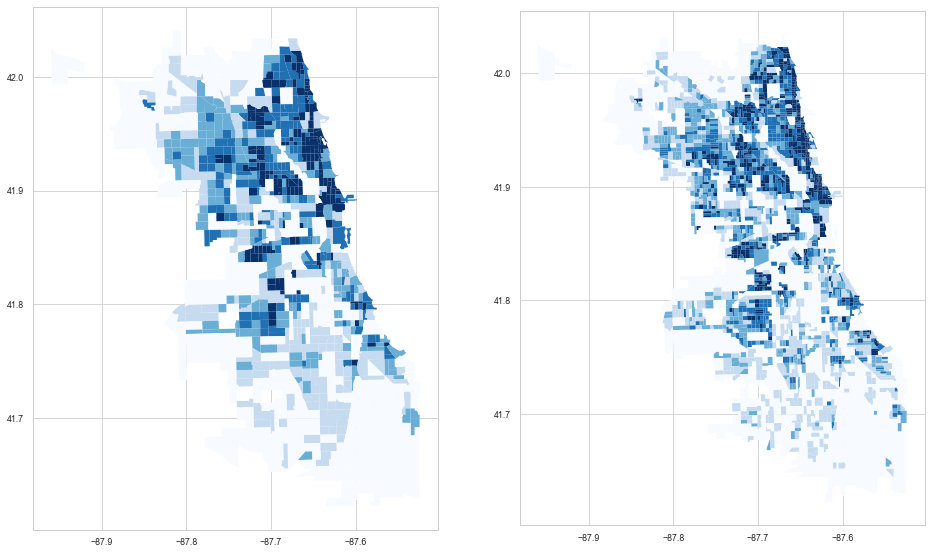

In [81]:
fig, ax = plt.subplots(1, 2,figsize=(16,16))

acs18_tract.plot('pop_dens',cmap='Blues',ax=ax[0], edgecolor='None',scheme='Quantiles')
acs18_blkgrp.plot('pop_dens',cmap='Blues',ax=ax[1], edgecolor='None',scheme='Quantiles')

In [82]:
home_acs = gpd.sjoin(home2,acs18_blkgrp)

In [83]:
# home_acs_tract = gpd.sjoin(home2,acs18_tract)

# 1. Explore

## 1.1 Check against Blk Grp population

Let's just check this against population and racial breakdown to see how we did. 

Join the cell data to ACS data

In [84]:
home3 = gpd.sjoin(home2,acs18_blkgrp,how='inner')
pop_blkgrp_cell = pd.merge(acs18_blkgrp,home3.groupby('GISJOIN')\
                                   .count()\
                                   .reset_index()[['GISJOIN','home_lng']]\
                    .rename(columns={'home_lng':'cell_pop'}),on='GISJOIN')

pop_blkgrp_cell = pd.merge(pop_blkgrp_cell,home3.fillna(0).groupby('GISJOIN')\
                                   .median()\
                                   .reset_index()[['GISJOIN','num_home_locs','std_lng','std_lat']])

pop_blkgrp_cell['pop_dens']=pop_blkgrp_cell['pop']/pop_blkgrp_cell['Shape_area']
pop_blkgrp_cell['cell_pop_dens']=pop_blkgrp_cell['cell_pop']/pop_blkgrp_cell['Shape_area']

pop_blkgrp_cell = pop_blkgrp_cell[~pop_blkgrp_cell['pop_dens'].isna()]
pop_blkgrp_cell['dens_ratio'] = pop_blkgrp_cell['cell_pop_dens']/pop_blkgrp_cell['pop_dens']

In [85]:
pop_blkgrp_cell['multiple_home_locs'] =pop_blkgrp_cell.apply(lambda x: 1 if x['num_home_locs']>=1+pop_blkgrp_cell.num_home_locs.describe()['std'] else 0,axis=1)
pop_blkgrp_cell['high_lng_std'] =pop_blkgrp_cell.apply(lambda x: 1 if x['std_lng']>=pop_blkgrp_cell.std_lng.describe()['mean']+pop_blkgrp_cell.std_lng.describe()['std'] else 0,axis=1)

In [86]:
# pop_blkgrp_cell[pop_blkgrp_cell.num_home_locs>1.5].to_file('multiple_home_locs.shp')
# pop_blkgrp_cell[pop_blkgrp_cell.std_lng>0.000032+2*0.000032].to_file('high_lng_std.shp')

### 1.1.1 Filter for prison and no cell data
There is one blk grp with a high pop and that is the cook country prison. :(


In [87]:
df1 = pop_blkgrp_cell[(pop_blkgrp_cell['pop']<=10000)&(pop_blkgrp_cell.cell_pop_dens.isna()==False)]
print('Orig Number of block groups: {}'.format(acs18_blkgrp.shape[0]))
print('Filtered Number of block groups: {}'.format(df1.shape[0]))

Orig Number of block groups: 2321
Filtered Number of block groups: 2173


### 1.1.2 Test best threshold

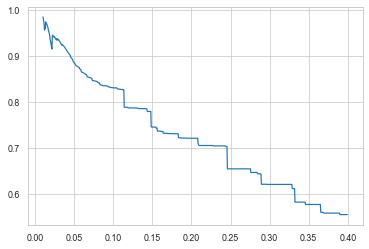

In [88]:
test = []
thres_ranges = np.arange(0.01,0.4,.0005)
for i in thres_ranges:
    df2 = df1[(df1.dens_ratio<i)]

    corr = np.corrcoef(df2['cell_pop_dens'],
                  df2['pop_dens'])[0][1]
    test.append(corr)
    
plt.plot(thres_ranges,test)

### 1.1.3 Best Threshold
Going with **0.11**

In [89]:
thres =0.11
df2 = df1[(df1.dens_ratio<thres)]

In [90]:
home_acs.shape

(129982, 48)

In [91]:
home_acs[home_acs.GISJOIN.isin(df2.GISJOIN)==True].shape[0]

87631

<AxesSubplot:>

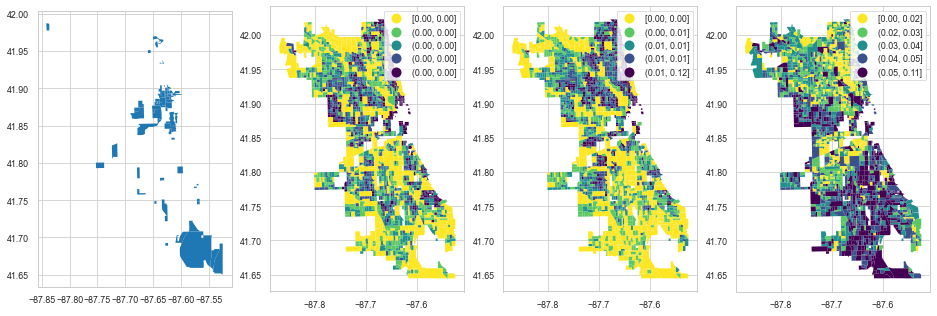

In [92]:
fig, ax = plt.subplots(1, 4,figsize=(16,16))

df1[(df1.dens_ratio>=thres)].to_file('highratioareas.shp')


df1[(df1.dens_ratio>=thres)].plot(ax=ax[0], edgecolor='None')
df2.plot('cell_pop_dens',cmap='viridis_r',ax=ax[1], edgecolor='None',scheme='Quantiles',legend=True)
df2.plot('pop_dens',cmap='viridis_r',ax=ax[2], edgecolor='None',scheme='Quantiles',legend=True)
df2.plot('dens_ratio',cmap='viridis_r',ax=ax[3], edgecolor='None',scheme='Quantiles',legend=True)




### 1.1.4 Correlations

In [93]:
from scipy.stats import spearmanr
from scipy.stats import kendalltau

print(np.corrcoef(df2['cell_pop_dens'],
                  df2['pop_dens']))

print(np.corrcoef(np.log(df2['cell_pop_dens']),
                  np.log(df2['pop_dens'])))

print(spearmanr(df2['cell_pop_dens'],df2['pop_dens']))
print(kendalltau(df2['cell_pop_dens'],df2['pop_dens']))


# print(spearmanr(np.log(pop_test['cell_pop']+1),np.log(pop_test['pop']+1)))

[[1.         0.82688651]
 [0.82688651 1.        ]]
[[1.         0.78149352]
 [0.78149352 1.        ]]
SpearmanrResult(correlation=0.7086643689788078, pvalue=1.3854e-320)
KendalltauResult(correlation=0.5269880868841712, pvalue=2.9316703328212014e-287)


#### 1.1.6 Scatter of the two

Text(0.5, 1.0, 'Residual Plot of Regression between Population for Cell vs ACS')

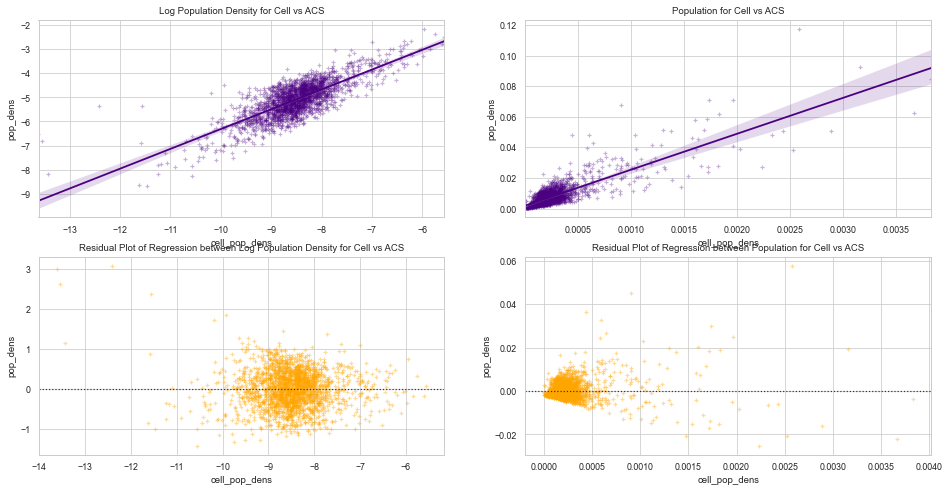

In [94]:
fix,ax = plt.subplots(2,2,figsize=(16,8))

sns.regplot(np.log(df2['cell_pop_dens']+.0000001),np.log(df2['pop_dens']+.0000001),marker='+',ci=98,truncate=True,color='indigo',ax=ax[0,0],scatter_kws={'marker':'+','alpha':0.3})
ax[0,0].set_title('Log Population Density for Cell vs ACS')
sns.residplot(np.log(df2['cell_pop_dens']+.0000001),np.log(df2['pop_dens']+.0000001),robust=True,color='orange',ax=ax[1,0],scatter_kws={'marker':'+','alpha':0.4})
ax[1,0].set_title('Residual Plot of Regression between Log Population Density for Cell vs ACS')


sns.regplot(df2['cell_pop_dens'],df2['pop_dens'],marker='+',ci=98,truncate=True,color='indigo',ax=ax[0,1],scatter_kws={'marker':'+','alpha':0.3})
ax[0,1].set_title('Population for Cell vs ACS')
sns.residplot(df2['cell_pop_dens'],df2['pop_dens'],robust=True,color='orange',ax=ax[1,1],scatter_kws={'marker':'+','alpha':0.4})
ax[1,1].set_title('Residual Plot of Regression between Population for Cell vs ACS')


### 1.1.3 Histogram of the two

<AxesSubplot:xlabel='pop_dens', ylabel='Density'>

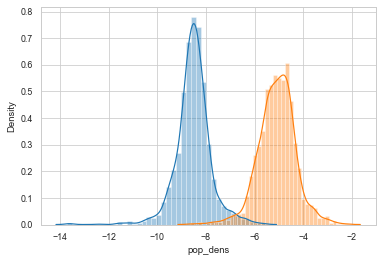

In [95]:
sns.distplot(np.log(df2['cell_pop_dens']),bins=40,norm_hist=True)
sns.distplot(np.log(df2['pop_dens']),bins=40,norm_hist=True)

### 1.1.4 Try 1: Using cell to predict pop for weights (Regression to find coeffcients)

I think this is the same as a correlation if I have no intercept and am regression on one variable

In [109]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence

df2['white_perc_norm'] = (df2['white_perc'] - df2['white_perc'].mean())/df2['white_perc'].std()
df2['black_perc_norm'] = (df2['black_perc'] - df2['black_perc'].mean())/df2['black_perc'].std()
df2['hispanic_perc_norm'] = (df2['hispanic_perc'] - df2['hispanic_perc'].mean())/df2['hispanic_perc'].std()
df2['higher_ed_perc_norm'] = (df2['higher_ed_perc'] - df2['higher_ed_perc'].mean())/df2['higher_ed_perc'].std()
df2['median_income_norm'] = (df2['median_income'] - df2['median_income'].mean())/df2['median_income'].std()
df2['num_home_locs_norm'] = (df2['num_home_locs'] - df2['num_home_locs'].mean())/df2['num_home_locs'].std()
df2['ln_cell_pop_dens'] = np.log(df2['cell_pop_dens'])
df2['ln_cell_pop'] = np.log(df2['cell_pop'])
df2['ln_pop_dens'] = np.log(df2['pop_dens'])



X = df2[['ln_cell_pop_dens','ln_cell_pop','black_perc','higher_ed_perc']].fillna(df2.mean())
X.loc[X.black_perc==0,'black_perc'] =0.000001
X.loc[X.higher_ed_perc==0,'higher_ed_perc'] =0.000001
# X = np.log(X)
X = sm.add_constant(X)
y = df2['ln_pop_dens']


Test of predicting cell

In [110]:
X1 = df2[['ln_pop_dens','black_perc','higher_ed_perc']].fillna(df2.mean())
X1 = sm.add_constant(X1)

y1 = df2['ln_cell_pop_dens']
mod1 = sm.OLS(y1,X1)
res1 = mod1.fit(cov_type='HC1')
y_pred1 = res1.predict(X1)


print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:       ln_cell_pop_dens   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     828.7
Date:                Tue, 02 Feb 2021   Prob (F-statistic):               0.00
Time:                        08:35:51   Log-Likelihood:                -1073.6
No. Observations:                2103   AIC:                             2155.
Df Residuals:                    2099   BIC:                             2178.
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -4.5898      0.081    -56.

                            OLS Regression Results                            
Dep. Variable:            ln_pop_dens   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     1708.
Date:                Tue, 02 Feb 2021   Prob (F-statistic):               0.00
Time:                        08:35:55   Log-Likelihood:                -746.49
No. Observations:                2103   AIC:                             1503.
Df Residuals:                    2098   BIC:                             1531.
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                4.7403      0.142  

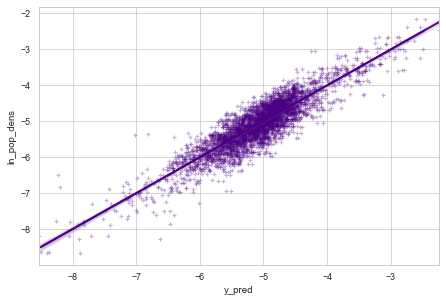

In [111]:
mod1 = sm.OLS(y,X)
res1 = mod1.fit(cov_type='HC3')
y_pred1 = res1.predict(X)
intercept1,slope1 = res1.params[0],res1.params[1]

df2['y_pred'] =y_pred1
print(res1.summary())
influence = OLSInfluence(res1)

# sns.regplot(y_pred1,y,marker='+',ci=98,truncate=True,color='indigo',scatter_kws={'marker':'+','alpha':0.3})
sns.regplot('y_pred','ln_pop_dens', data= df2,marker='+',ci=98,truncate=True,color='indigo',scatter_kws={'marker':'+','alpha':0.3})
# ax[1].set_title('Residsual Plot of Regression between Log Population Density for Cell vs ACS')
plt.tight_layout(pad=0)
plt.savefig('Using/Images/pred_actual_scatter_jan27.png')

from sklearn.preprocessing import PolynomialFeatures
polynomial_features= PolynomialFeatures(degree=4)
Xp = polynomial_features.fit_transform(X)
modp = sm.OLS(y,Xp)
resp = modp.fit(cov_type='HC1')
y_predp = resp.predict(Xp)
y_resid = y-y_predp
print(resp.summary())


sns.regplot(y_predp,y,marker='+',ci=98,truncate=True,color='indigo',scatter_kws={'marker':'+','alpha':0.3})

plt.show()

df2['y_pred'] =y_predp

<AxesSubplot:xlabel='Log Population Density', ylabel='Density'>

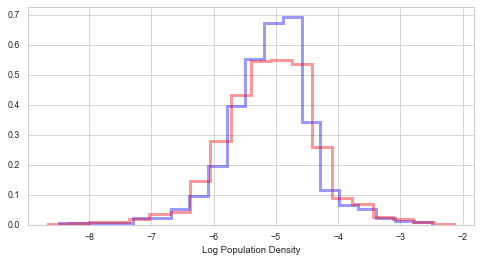

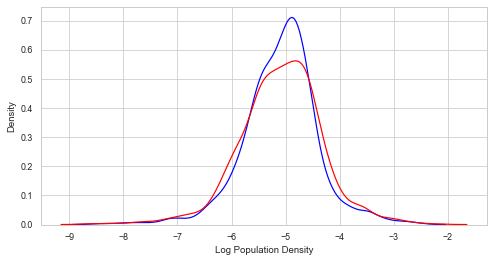

In [30]:
fig, ax = plt.subplots(1,1,figsize=(8,4))

sns.distplot(y_predp,bins=20,color='blue',label='Cell',norm_hist=True,hist=True,hist_kws={
                       "histtype": "step",
                       "linewidth": 3},kde=False)
sns.distplot(y,bins=20,color='red',label='ACS',norm_hist=True,hist=True,hist_kws={
                       "histtype": "step",
                       "linewidth": 3},axlabel='Log Population Density',kde=False)

fig, ax = plt.subplots(1,1,figsize=(8,4))

sns.distplot(y_predp,bins=20,color='blue',label='Cell',norm_hist=True,hist=False,hist_kws={
                       "histtype": "step",
                       "linewidth": 3},kde=True)
sns.distplot(y,bins=20,color='red',label='ACS',norm_hist=True,hist=False,hist_kws={
                       "histtype": "step",
                       "linewidth": 3},axlabel='Log Population Density',kde=True)

Measure the influence of certain points and remove these

In [112]:
df2['resid_std'] = influence.resid_std
df2['influence'] = influence.influence
influence_std = df2.influence.describe()['std']

                            OLS Regression Results                            
Dep. Variable:            ln_pop_dens   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     1783.
Date:                Tue, 02 Feb 2021   Prob (F-statistic):               0.00
Time:                        08:36:08   Log-Likelihood:                -733.62
No. Observations:                2102   AIC:                             1477.
Df Residuals:                    2097   BIC:                             1506.
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                4.7697      0.139  

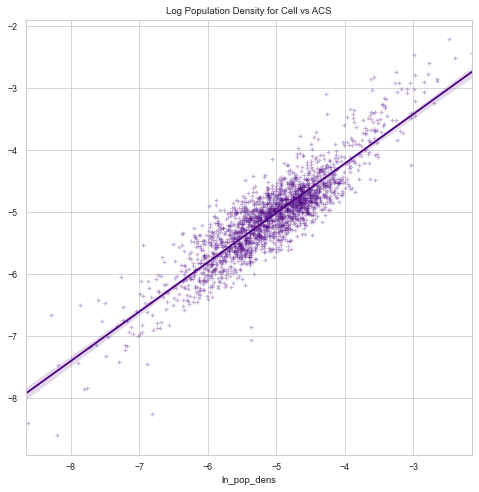

                            OLS Regression Results                            
Dep. Variable:            ln_pop_dens   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     2202.
Date:                Tue, 02 Feb 2021   Prob (F-statistic):               0.00
Time:                        08:36:09   Log-Likelihood:                -569.30
No. Observations:                2102   AIC:                             1279.
Df Residuals:                    2032   BIC:                             1674.
Df Model:                          69                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.0651     17.222      0.933      0.3

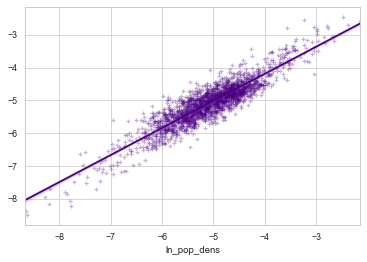

In [113]:
# df2_1 = df2[(df2.influence<=influence_std)&\
#             (df2.influence>=-influence_std)]
df2_1 = df2[df2.GISJOIN!='G17003108106001']
# df2[(df2.influence>influence_std)|(df2.influence<-influence_std)].to_file('highinfluenceareas.shp')


X1 =X.loc[df2_1.index]
y1 = y.loc[df2_1.index]


mod2 = sm.OLS(y1,X1)
res2 = mod2.fit(cov_type='HC1')
y_pred2 = res2.predict(X1)
intercept2,slope2 = res2.params[0],res2.params[1]

print(res2.summary())

fix,ax = plt.subplots(1,1,figsize=(8,8))
sns.regplot(y1,y_pred2,marker='+',ci=98,truncate=True,color='indigo',ax=ax,scatter_kws={'marker':'+','alpha':0.3})
ax.set_title('Log Population Density for Cell vs ACS')
# sns.residplot(y1,y_pred2,robust=True,color='orange',ax=ax,scatter_kws={'marker':'+','alpha':0.4})
# ax.set_title('Residual Plot of Regression between Log Population Density for Cell vs ACS')
plt.show()

from sklearn.preprocessing import PolynomialFeatures
polynomial_features= PolynomialFeatures(degree=4)
Xp1 = polynomial_features.fit_transform(X1)
modp2 = sm.OLS(y1,Xp1)
resp2 = modp2.fit(cov_type='HC1')
y_predp2 = resp2.predict(Xp1)
print(resp2.summary())
sns.regplot(y1,y_predp2,marker='+',ci=98,truncate=True,color='indigo',scatter_kws={'marker':'+','alpha':0.3})
plt.show()


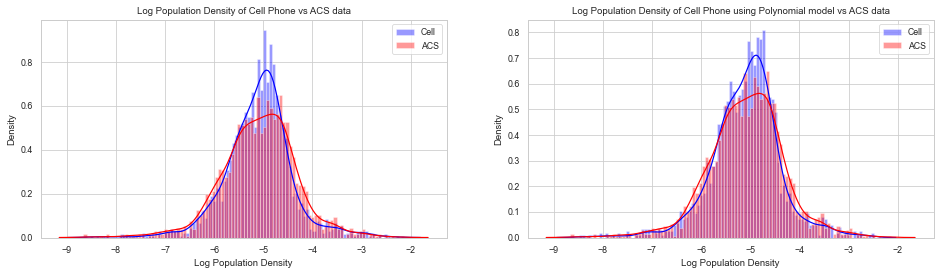

In [114]:
fig, ax = plt.subplots(1,2,figsize=(16,4))

sns.distplot(y_pred1.values,bins=100,ax=ax[0],color='blue',label='Cell',norm_hist=True,hist=True)
sns.distplot(y,bins=100,ax=ax[0],color='red',label='ACS',norm_hist=True,hist=True,axlabel='Log Population Density')
ax[0].set_title('Log Population Density of Cell Phone vs ACS data')
ax[0].legend()
# ax[0].set_xlim([0,0.05])

sns.distplot(y_predp,bins=100,ax=ax[1],color='blue',label='Cell',norm_hist=True,hist=True)
sns.distplot(y,bins=100,ax=ax[1],color='red',label='ACS',norm_hist=True,hist=True,axlabel='Log Population Density')
ax[1].set_title('Log Population Density of Cell Phone using Polynomial model vs ACS data')
ax[1].legend()
# ax[1].set_xlim([0,0.05])
# # plt.savefig('Using/Images/cell_pop_dens.png')



### 1.1.5 Try 2: Use ML to predict pop with cell 

Gradient boosted regressor

In [115]:
import sklearn.ensemble as sk_ens
import sklearn.linear_model as sk_lin

from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split


X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=.3,)


model = sk_ens.GradientBoostingRegressor(max_depth=2,learning_rate=.1,alpha=.7)
model = sk_ens.GradientBoostingRegressor(max_depth=2,learning_rate=.1,alpha=.7).fit(X_train,y_train)


#### Tuning hyperparameters
# param_gb = {
# #     'alpha': [.1, .2, .3, .4,.5,.6,.7,.8,.9],
# #     'learning_rate': [.1, .2, .3, .4,.5,.6,.7,.8,.9],
#         'max_depth' :[1,2,3,4,5,6,7,8,9,10]
#              }
# clf = GridSearchCV(model, param_gb)
# clf.fit(X_train,y_train)
# sorted(clf.cv_results_.keys())
# y_pred = clf.predict(X_test)
# scores = clf.cv_results_['mean_test_score']
# plt.plot([1,2,3,4,5,6,7,8,9,10], scores)
# plt.show()


y_pred = model.predict(X_test)
print(np.mean(cross_val_score(model, X_train, y_train, cv=10)))
print(r2_score(y_test,y_pred))

y_pred_gbr = model.predict(X)
print(r2_score(y,y_pred_gbr))



0.786117983437638
0.779496878078226
0.8244582647368349


<AxesSubplot:xlabel='Log Population Density'>

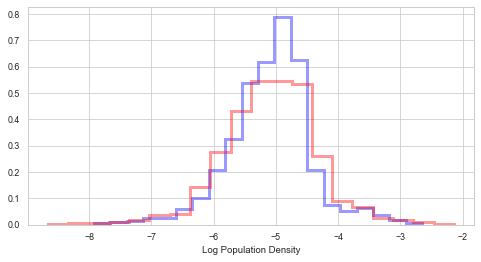

In [116]:
fig, ax = plt.subplots(1,1,figsize=(8,4))

sns.distplot(y_pred_gbr,bins=20,color='blue',label='Cell',norm_hist=True,hist=True,hist_kws={
                       "histtype": "step",
                       "linewidth": 3},kde=False)
sns.distplot(y,bins=20,color='red',label='ACS',norm_hist=True,hist=True,hist_kws={
                       "histtype": "step",
                       "linewidth": 3},axlabel='Log Population Density',kde=False)

Stochastic Gradient Descent

In [117]:

model_sgd = sk_lin.ARDRegression(alpha_1 = 200,alpha_2=2,lambda_1= .000000000001).fit(X_train,y_train)
model_sgd = sk_lin.BayesianRidge().fit(X_train,y_train)
# model = sk_ens.GradientBoostingRegressor(max_depth=2,learning_rate=.1,alpha=.7).fit(X_train,y_train)


# ### Tuning hyperparameters
# test_range = np.arange(.000000000001,.000000001,.0000000001)
# param_sgd = {
#     'lambda_1': test_range,
#              }
# clf = GridSearchCV(model_sgd, param_sgd)
# clf.fit(X_train,y_train)
# sorted(clf.cv_results_.keys())
# y_pred = clf.predict(X_test)
# scores = clf.cv_results_['mean_test_score']
# plt.plot(test_range, scores)
# plt.show()


y_pred = model_sgd.predict(X_test)
print(np.mean(cross_val_score(model_sgd, X_train, y_train, cv=10)))
print(r2_score(y_test,y_pred))

y_pred_sgd = model_sgd.predict(X)
print(r2_score(y,y_pred_sgd))



0.7947856911897971
0.7708484184114786
0.7924454553420491


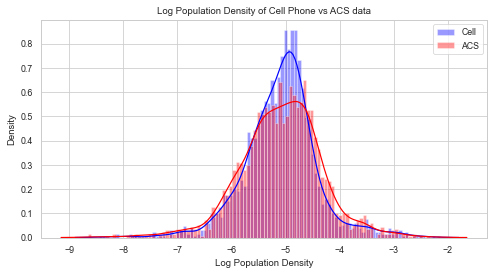

In [118]:
fig, ax = plt.subplots(1,1,figsize=(8,4))

sns.distplot(y_pred_sgd,bins=100,color='blue',label='Cell',norm_hist=True,hist=True)
sns.distplot(y,bins=100,color='red',label='ACS',norm_hist=True,hist=True,axlabel='Log Population Density')
ax.set_title('Log Population Density of Cell Phone vs ACS data')
ax.legend()
# ax.set_xlim([0,0.05])

In [119]:

model_rf = sk_ens.RandomForestRegressor(min_samples_split=2,max_depth=6).fit(X_train,y_train)


# test_range =np.arange(1,10,1)
# # param_rf = {'n_estimators': test_range,
# #              }
# param_rf = {'max_depth': test_range,
#              }

# clf_rf = GridSearchCV(model_rf, param_rf)
# clf_rf.fit(X_train,y_train)
# sorted(clf_rf.cv_results_.keys())
# y_pred_rf = clf_rf.predict(X_test)
# scores_rf = clf_rf.cv_results_['mean_test_score']
# plt.plot( test_range, scores_rf)
# plt.show()


y_pred = model_rf.predict(X_test)
print(np.mean(cross_val_score(model_rf, X_train, y_train, cv=10)))
print(r2_score(y_test,y_pred))

y_pred_rf = model_rf.predict(X)
print(r2_score(y,y_pred_rf))



0.7741727329003787
0.7735103424696474
0.8315571819844809


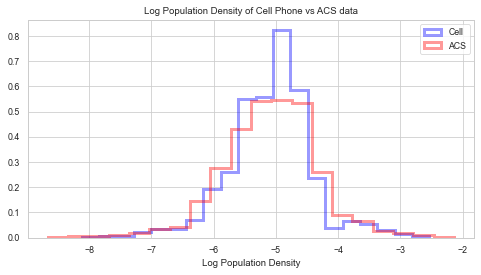

In [120]:
fig, ax = plt.subplots(1,1,figsize=(8,4))

sns.distplot(y_pred_rf,bins=20,color='blue',label='Cell',norm_hist=True,hist=True,hist_kws={
                       "histtype": "step",
                       "linewidth": 3},kde=False)
sns.distplot(y,bins=20,color='red',label='ACS',norm_hist=True,hist=True,hist_kws={
                       "histtype": "step",
                       "linewidth": 3},axlabel='Log Population Density',kde=False)
ax.set_title('Log Population Density of Cell Phone vs ACS data')
ax.legend()

## 1.3 Create Weights
Now we want to get a sense of the over/under representation of different racial and SES sub-populations. In order to do this, I'm going to re-weight these numbers by how over-/under-represented each block group is for the cell phone data vs the population data. 

In other words, 
$$
w_i = \frac{p_i}{P}*\frac{C}{c_i}
$$
where $C$ = Total cell phone population, $P$ = total ACS population, and $p_i$,$c_i$ are the respective block group populations. 

In [121]:
# p = df1
# a = acs18_blkgrp[acs18_blkgrp.GISJOIN.astype(str).isin(p.GISJOIN.astype(str).unique())]

# p['weights'] = (a['pop']/a['pop'].sum()+.00001)/(p['cell_pop']/p['cell_pop'].sum())
# p['weights1'] = p['cell_pop']/p['pop']
# p['weights2'] = p['pop']/p['cell_pop']


df2['predicted_pop'] = np.exp(df2['y_pred'])*df2['Shape_area']
df2['weights'] = df2['pop']/df2['predicted_pop']

In [122]:
df2['weights'].describe()

count    2103.000000
mean        1.050072
std         0.327144
min         0.259022
25%         0.819511
50%         1.014269
75%         1.246876
max         3.192394
Name: weights, dtype: float64

<AxesSubplot:xlabel='weights', ylabel='Density'>

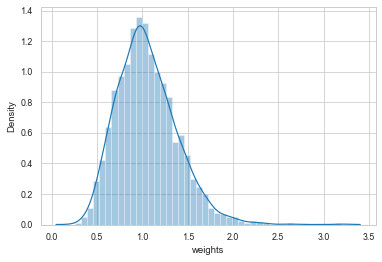

In [123]:
sns.distplot(df2['weights'] )

## 1.4 Compare demographics

In [124]:
df2['median_income'] = df2['median_income'].fillna(df2['median_income'].mean())

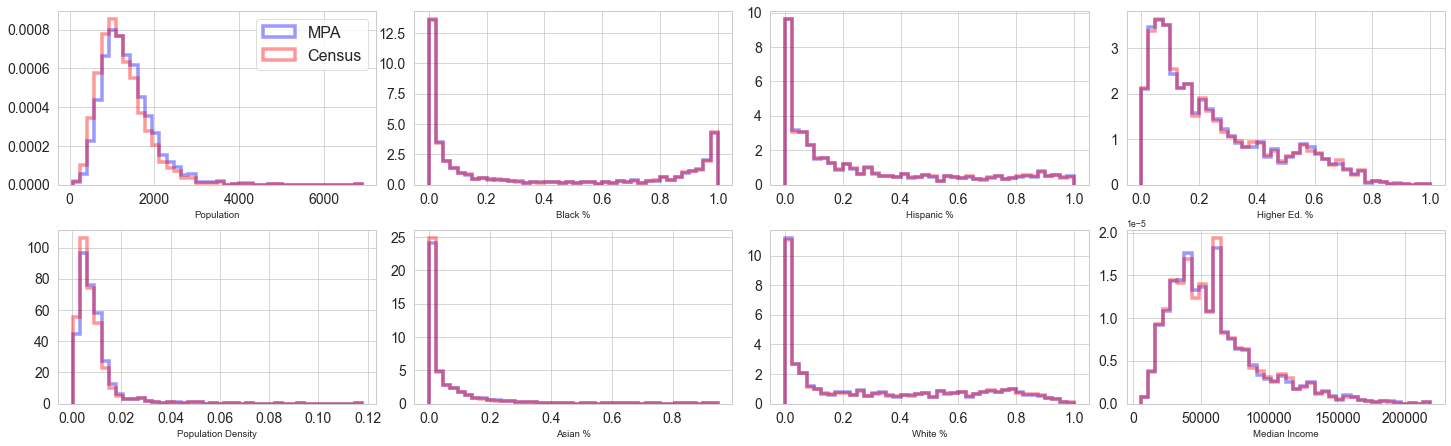

In [136]:
p=df2.drop(columns='geometry')
lw = 3.5
num_bins=40
color_cell = 'blue'
color_acs = 'red'
cols_to_plot = {'Population':'pop',
                'Black %':'black_perc',
                              
                'Hispanic %':'hispanic_perc',
                'Higher Ed. %':'higher_ed_perc',

                'Population Density':'pop_dens',
               'Asian %':'asian_perc',
               'White %':'white_perc',
               'Median Income':'median_income',}
hist_on=False
kde_on=True
histstep_on=True
## Hispanic
fig, ax = plt.subplots(2,4,figsize=(20,6))
counter = 0

for k,v in cols_to_plot.items():
    ax_idx = [int(counter/4),(counter %4)]
    
        
    if histstep_on==True:
    
        sns.distplot(p[v],hist_kws={'weights': p['weights'],
                                      "histtype": "step",
                                       "linewidth": lw},
                     bins=num_bins,hist=True,norm_hist=True, 
                     kde=False,ax=ax[ax_idx[0],ax_idx[1]],
                     color=color_cell,label='MPA')
        sns.distplot(p[v],bins=num_bins, 
                     norm_hist=True,
                     kde=False,
                     ax=ax[ax_idx[0],ax_idx[1]],
                     color=color_acs,
                     label='Census',
#                      legend = show_legend,
                     axlabel=k, 
                     hist_kws={
                         "histtype": "step",
                               "linewidth": lw})    
        ax[ax_idx[0],ax_idx[1]].tick_params(axis='both', which='major', labelsize=14)
        
    else: 
        print(v)
        sns.kdeplot(data=p,x=v,cut=0,
                    weights='weights',
                    ax=ax[ax_idx[0],ax_idx[1]],
                    label='MPA')
        sns.kdeplot(data=p,x=v,cut=0,
                    ax=ax[ax_idx[0],ax_idx[1]],color=color_acs,label='ACS',axlabel=k)

    if ax_idx == [0,0]:
        ax[ax_idx[0],ax_idx[1]].legend(fontsize=16)

    counter +=1
    

plt.tight_layout(pad=0)
plt.savefig('Using/Images/Predicted_vs_Actual_SocioeconDist.png')

## Export home data

In [102]:
df2.to_pickle('home_pred_jan27.pickle')